# DRL for Cartpole, pytorch

Setting up DRL training for Cartpole - this is not a full DQN, but much simplified!


## 1. Setting up python environment

In [17]:
import math, random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]  # For Atari games, when using RAM states this should be 128 for RAM
action_size = env.action_space.n             # Should be 6 for Pong

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
#USE_CUDA = torch.cuda.is_available()
#Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## A Simple Neural Network as a Q-Function

Setting up the Deep Q-Network as an action-value function. It provides for each possible action an estimated value for an additionally given state. An get_action method selects an action greedily.

In [19]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.layers(x)

    def get_action(self, state, action_space):
        """
        Select an action using a greedy policy, sometimes.
        :param state: Current state (numpy array or tensor).
        :param action_space: Action space of the environment for random actions.
        :return: Selected action.
        """
        # Do something better ... -- should adapt over time as well
        if random.randint(1, 10) == 1:
            return action_space.sample()
        else:
            # Greedy action (exploitation)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            if torch.cuda.is_available():
                state_tensor = state_tensor.cuda()
            q_values = self.forward(state_tensor)
            return q_values.argmax(dim=1).item()


### Visualize training

In [20]:
def plot_dqn_learning(env_steps, rewards):
    clear_output(True)
    plt.figure(figsize=(12, 6))
    plt.title('Environment Steps: %s. - Reward: %s' % (env_steps[-1], np.mean(rewards[-10:])))
    plt.plot(env_steps, rewards, label="Rewards")
    plt.xlabel("Environment Steps")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

---

## Training run

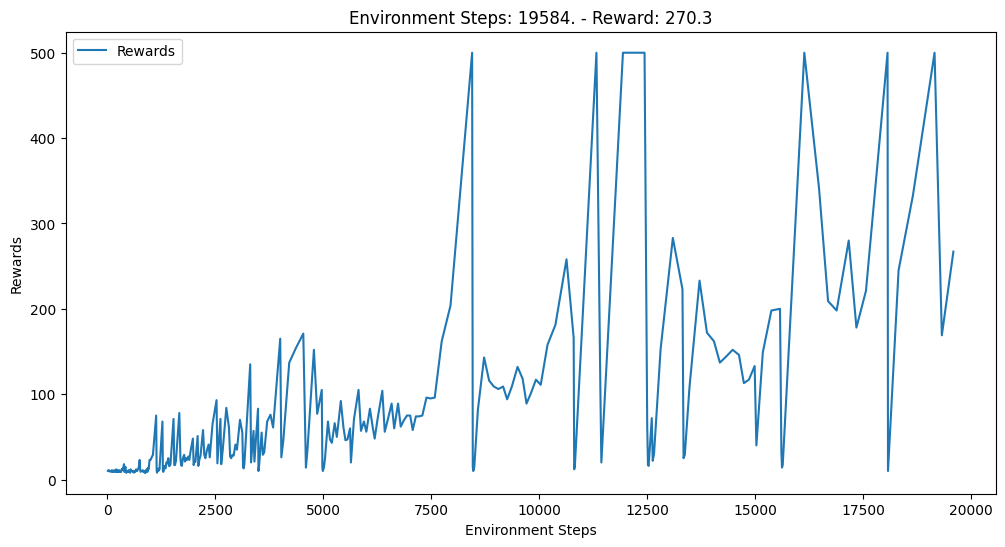

In [24]:
# Initialize the Q-network
q_net = DQN(state_size, action_size)         # Online network

# If using CUDA, move models to GPU
#USE_CUDA = torch.cuda.is_available()  # Check for CUDA availability
#if USE_CUDA:
#    q_net = q_net.cuda()
#    print("Model moved to GPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define optimizer for the online network
learning_rate = 0.001  # 0.001, for more complex tasks as Atari games, should be much smaller 
optimizer = torch.optim.Adam(q_net.parameters(), lr=learning_rate)

print("Q-networks and optimizer are set up.")

# Training parameters
gamma = 0.99
total_steps = 20_000 

# Initialize reward and environment step tracking, only for visualization
dqn_all_rewards = []
dqn_total_env_steps = []  # Track environment steps
dqn_episode_reward = 0

state, _ = env.reset()
# Training loop
for step in range(1, total_steps + 1):
    # Select an action from the q-net
    action = q_net.get_action(state, env.action_space)

    # Apply the action in the environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    # We don't care how the enviromnet terminated
    done = terminated or truncated

    # Accumulate reward for the current episode
    # only for data collection
    dqn_episode_reward += reward

    # Update the Q-network using the current step information
    with torch.no_grad():
        next_q_value = q_net(torch.FloatTensor(next_state).unsqueeze(0).to(device)).max(1)[0].item()
        target_q_value = reward + gamma * next_q_value * (1 - done)

     # Convert state to a PyTorch tensor, add batch dimension, and move to device for neural network input
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    # Convert the target Q-value to a PyTorch tensor and move it to the same device as the model
    target_tensor = torch.FloatTensor([target_q_value]).to(device)

    # Compute the Q-value for the current state-action pair
    q_value = q_net(state_tensor)[0, action]

    # Compute the loss
    loss = torch.nn.functional.mse_loss(q_value, target_tensor)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Reset environment if episode ends
    if done:
        state, _ = env.reset()
        dqn_all_rewards.append(dqn_episode_reward)  # Track episode reward
        dqn_total_env_steps.append(step)  # Track total steps at episode end
        dqn_episode_reward = 0  # Reset for next episode
    else:
        state = next_state

    # Plot rewards and episode lengths periodically
    if (step > 500) and step % 1000 == 0:  # Plot every 2 episodes
        plot_dqn_learning(dqn_total_env_steps, dqn_all_rewards)


In [25]:
import torch
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time, sys

# Function to play the game and visualize
def play_game_with_model(env_vis, q_net, preprocess_fn=None):
    """
    Let the trained Q-network play the game and visualize it in a notebook.
    As this can cause problems, added exception handling.
    
    :param env_vis: Cartpole environment for visualization.
    :param q_net: Trained Q-network.
    :param preprocess_fn: Optional preprocessing function for frames.
    """
    state, _ = env_vis.reset()
    done = False
    total_reward = 0  # Track the cumulative reward

    try:
        while not done:
            action = q_net.get_action(state, env.action_space)
            # Take the action in the environment
            next_state, reward, terminated, truncated, _ = env_vis.step(action)
            done = terminated or truncated

            # Accumulate the reward
            total_reward += reward

            # Advance state, preprocessing would be integrated
            state = next_state

            # Render the environment
            frame = env_vis.render()
            plt.imshow(frame)
            plt.axis("off")
            clear_output(wait=True)
            plt.pause(0.02)


    except KeyboardInterrupt:
        print("\nVisualization stopped")

    finally:
        env_vis.close()
        print(f"Total Reward: {total_reward}")


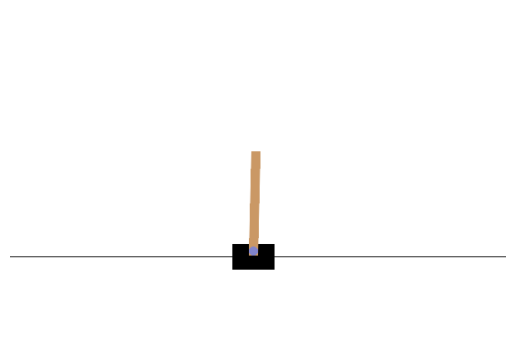

Total Reward: 500.0


In [26]:
env_vis = gym.make("CartPole-v1", render_mode="rgb_array")
play_game_with_model(env_vis, q_net)